In [20]:
"""Python script for filtering lists and plotting graphs with the distribution of distant Solar system objects.
Data source: https://www.minorplanetcenter.net/iau/MPCORB.html
Format description: http://www.minorplanetcenter.org/iau/info/MPOrbitFormat.html
Dependencies installation:
python -m pip install numpy pandas matplotlib
To make Jupyter Notebook work in VS code, run
python -m pip install jupyter ipykernel
"""

import numpy as np
import pandas as pd


PLOTS_DIR = "../../../plots/solarsystem/"
DATA_DIR = "../../../data/solarsystem/"
DATA = np.genfromtxt(
    DATA_DIR + 'MPCORB.DAT.gz',
    usecols=(0, 1, 8, 10, 11, 13,
             14, 15, 20, 21, 22),
    skip_header=43,
    delimiter=(
        7, 6, 7, 5, 10,
        11, 11, 11, 11, 12,
        14, 2, 10, 6, 4,
        10, 5, 4, 4, 11,
        5, 28, 9
    ),
    dtype=[
        ("Names", "U7"), ("H", "f8"), ("G", "f8"), ("Ep", "U5"), ("M", "f8"),
        ("Peri", "f8"), ("Node", "f8"), ("i", "f8"), ("e", "f8"), ("n", "f8"),
        ("a", "f8"), ("U", "int"), ("Ref", "U10"), ("Obs", "int"), ("Opp", "int"),
        ("Arc", "U9"), ("rms", "f8"), ("p1", "U3"), ("p2", "U3"), ("Com", "U10"),
        ("Flags", "U4"), ("Desig", "U27"), ("Lastobs", "int"),
    ])


In [34]:
# Filtering trans-Neptunian objects (TNO) by semi-major axis
# Neptune has a = 30.07 AU, so we are also looking for large Centaurs.
# Also 2005 QU182 has a = 112.2 AU
ALIM = (29, 113.3)
# Limits for bodies up to Sedna (a = 549.6 AU)
# ALIM = (28, 552)
# Limits for bodies up to Leleakuhonua (a = 1483 AU, H = 5.57)
# ALIM = (28, 7500)
Filtered = DATA[DATA["a"] > ALIM[0]]
Filtered = Filtered[Filtered["a"] <= ALIM[1]]
Filtered = pd.DataFrame(Filtered)

# Filtering objects by absolute magnitude H
# H = -1.3 is the approximate limit for including Eris in the sample,
# H = 5 is common boundary for brightest TNO objects:
Filtered = Filtered[Filtered["H"].between(-1.3, 5.6)]
# All distant objects have Flags == "000A":
# Filtered = Filtered[Filtered["Flags"] == "000A"]

# Get only numbered objects:
# Filtered = Filtered[Filtered["Desig"].str.contains("(", regex=False)]

# Filtered = Filtered.sort_values(by="H")
Filtered = Filtered.sort_values(by="a", ascending=False)
print("Total number of objects:", len(Filtered))
printing_limit = 25
print(Filtered[["H", "a", "U", "Opp", "Arc", "Desig", "Lastobs"]][:printing_limit].to_string(index=False))  # "Flags",

Total number of objects: 230
   H          a  U  Opp       Arc                       Desig  Lastobs
3.74 112.164726  1   24 1974-2025 (303775) 2005 QU182         20251110
4.12 109.994319  9    1    3 days          2020 MK53          20200625
3.48 109.925461  6    7 2006-2022          2014 UZ224         20221007
5.47 106.735682  4    6 2012-2018          2014 ST373         20181118
4.81 100.944688  4   13 2010-2025 (668381) 2011 WJ157         20250318
4.66 100.699138  6    7 2008-2021          2014 US277         20211201
4.22  99.718058  2   16 2008-2025 (528381) 2008 ST291         20250702
5.19  98.015597  1   15 2010-2025 (552555) 2010 ER65          20250402
4.84  92.482495  1   27 1980-2025  (26181) 1996 GQ21          20250726
4.59  92.273130  0   25 1976-2025 (145451) Rumina             20250120
4.99  90.046380  1   20 2002-2025 (307982) 2004 PG115         20250930
4.96  86.260671  9    1   29 days          2003 UA292         20031120
5.41  84.893436  1   26 1996-2025  (15874) 1996 

In [39]:
# Import data for selected TNO, see https://en.wikipedia.org/wiki/List_of_possible_dwarf_planets
from tnodata import data, data_nam, data_numbered, EXISTING_NAMES

# Select only designation, semi-major axis, absolute magnitude, uncertainty parameter:
Filtered_with_diam = Filtered[["Desig", "a", "H", "U"]].copy()

Filtered_with_diam["Name"] = Filtered_with_diam["Desig"].str.split(")").str[-1].str.strip()
# Names verification:
# print(Filtered_with_diam["Name"].to_string(index=False))

# Diameter estimates from the H and limiting albedo values, see P. Pravec et al., 2012, 2012Icar..221..365P
# and P. Pravec and A.W. Harris, 2007, 2007Icar..190..250P: https://space.asu.cas.cz/~asteroid/binastdata.htm
Filtered_with_diam["Diam1"] = 1329 * 10**(-Filtered_with_diam["H"]/5)/np.sqrt(0.5)
Filtered_with_diam["Diam2"] = 1329 * 10**(-Filtered_with_diam["H"]/5)/np.sqrt(0.04)
Filtered_with_diam["DiamMean"] = np.round((Filtered_with_diam["Diam1"] + Filtered_with_diam["Diam2"])/2)
# Actually we didn't calculate standard deviation (dispersion) here:
Filtered_with_diam["DiamStd"] = np.round(np.abs(Filtered_with_diam["Diam1"] - Filtered_with_diam["Diam2"]))

Filtered_with_diam = Filtered_with_diam.sort_values(by="DiamMean", ascending=False)
Filtered_with_diam = Filtered_with_diam[["Name", "a", "Diam1", "Diam2", "DiamMean", "DiamStd", "U"]]

# FILTERED_CANDIDATES_NUM = len(Filtered_with_diam)
print("Number of objects with selected ones:", len(Filtered_with_diam))
Filtered_with_diam = Filtered_with_diam[~Filtered_with_diam['Name'].isin(EXISTING_NAMES)]
print("Number of objects without selected ones:", len(Filtered_with_diam))

# Exclude objects with a diameter estimate smaller than Mimas (~400 km):
Candidates = Filtered_with_diam[Filtered_with_diam["DiamMean"] > 399]
# Note that 2002 TX300 and 2003 OP32 is in the list, but they are actually smaller in diameter than the Mimas 
print("Number of filtered objects without selected:", len(Candidates))
print(Candidates[:printing_limit].to_string(index=False))
# Exclude Triton, Pluto, Eris, Haumea, Makemake, Charon, Dysnomia (7) and Sedna (8)
TOTAL_CANDIDATES_NUM = len(EXISTING_NAMES) + len(Candidates) - 8


Number of objects with selected ones: 230
Number of objects without selected ones: 198
Number of filtered objects without selected: 92
      Name          a      Diam1       Diam2  DiamMean  DiamStd  U
2002 TX300  43.477488 375.007522 1325.851808     850.0    951.0  1
 2021 DR15  67.700137 356.483948 1260.361085     808.0    904.0  5
 2018 VG18  82.023225 306.224531 1082.667214     694.0    776.0  6
 2003 OP32  43.174933 297.879063 1053.161526     676.0    755.0  1
 2010 KZ39  44.985334 295.148091 1043.506083     669.0    748.0  4
 2021 LL37  55.636753 285.785361 1010.403834     648.0    725.0  6
 2020 MK53 109.994319 281.864239  996.540573     639.0    715.0  9
2015 KH162  61.585117 281.864239  996.540573     639.0    715.0  2
2001 UR163  51.765434 279.280092  987.404234     633.0    708.0  1
 2005 RR43  43.519986 279.280092  987.404234     633.0    708.0  1
2004 XA192  47.503554 276.719637  978.351658     628.0    702.0  1
2008 ST291  99.718058 269.178258  951.688859     610.0    683

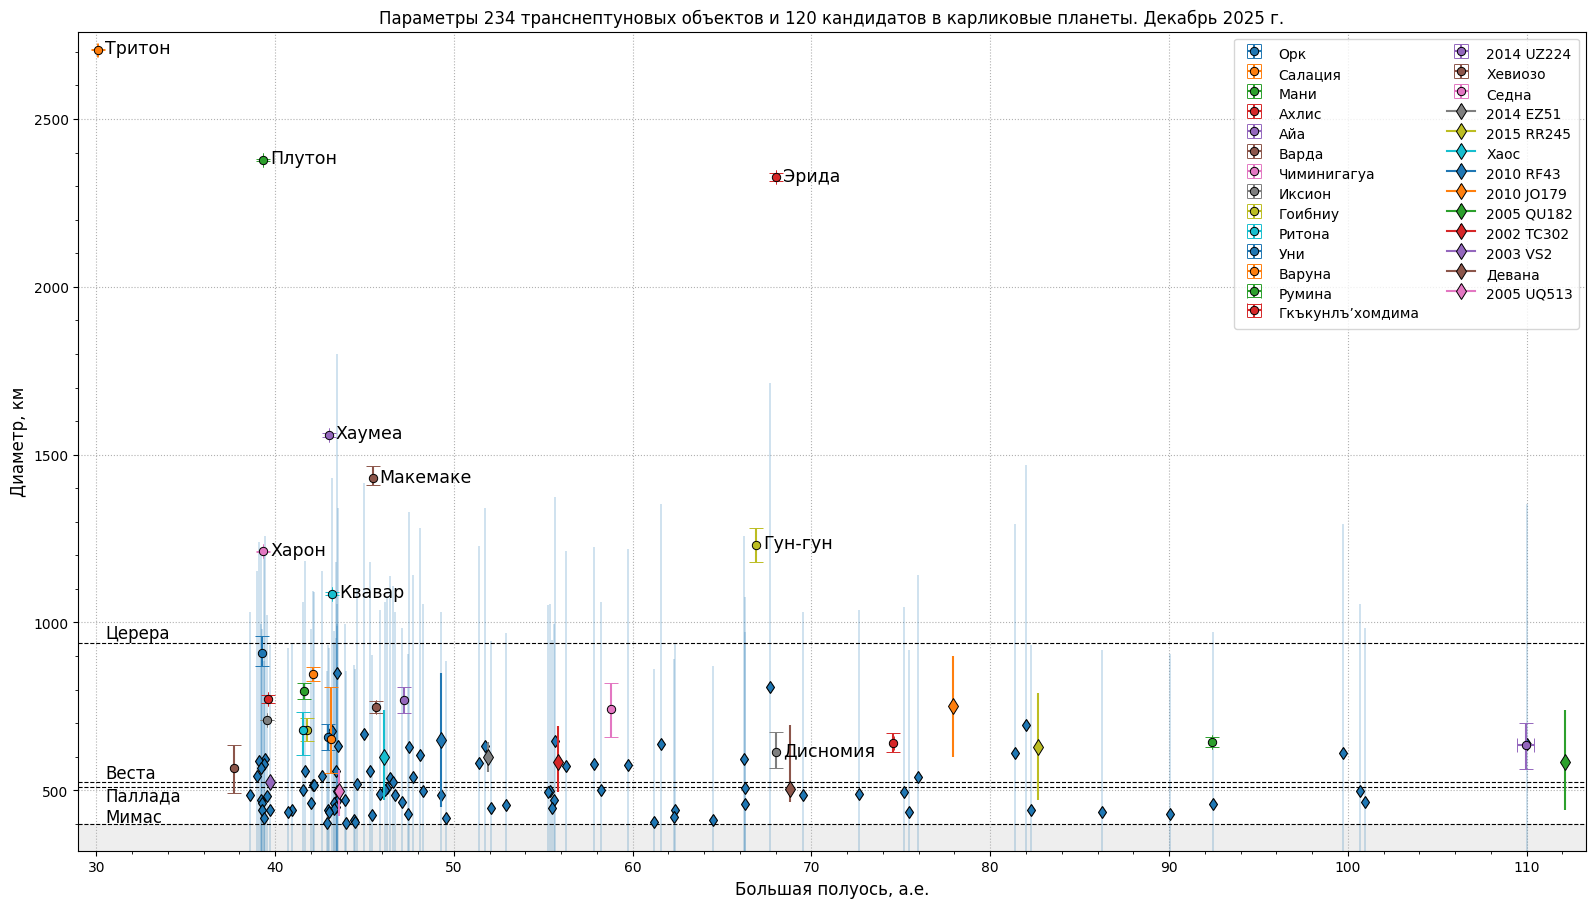

In [40]:
from datetime import datetime
import locale

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


# LOC = "en_US"
LOC = "ru_RU"
locale.setlocale(locale.LC_ALL, LOC)
today = datetime.now()
MON, YR = today.strftime("%B"), today.year

fig, ax = plt.subplots(figsize=(16, 9))
fig.subplots_adjust(0.048, 0.06, 0.99, 0.97)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Set the linewidth of the errorbar lines:
ELW = 0.3
# ELW = 0.5
XLIMS = (ALIM[0], ALIM[1])
# XLIMS = (37, ALIM[1])
# Y axis is limited by Triton (2707 km) and Mimas (400 km) diameters
YLIMS = (320, 2760)
# Y axis is limited by Pluto (2377 km) and Mimas (400 km) diameters
# YLIMS = (320, 2420)

# X position of of horizontal line labels
XAN = 30.5
# XAN = 102
# XAN = 520
# X offset between marker and label
XANN = 0.4
# XANN = 2.5
DPI = 160

# plt.errorbar(Filtered_with_diam["a"], Filtered_with_diam["DiamMean"], Filtered_with_diam["DiamStd"],
#              marker="d", ms=6, ls="none", markeredgecolor="k", mew=0.8, elinewidth=ELW,
#              )
plt.errorbar(Candidates["a"], Candidates["DiamMean"], Candidates["DiamStd"],
             marker="d", ms=6, ls="none", markeredgecolor="k", mew=0.8, elinewidth=ELW,
             )

for k, d in data_nam.items():
    plt.errorbar(d[1], d[3], xerr=([d[2][0]], [d[2][1]]), yerr=([d[4][0]], [d[4][1]]),
                 fmt='o', capsize=5, markeredgecolor="k", mew=0.7, zorder=11)
    t = plt.annotate(d[0], (d[1] + XANN, d[3] - 10), fontsize=12.5, zorder=11)

for k, d in data.items():
    plt.errorbar(d[1], d[3], xerr=([d[2][0]], [d[2][1]]), yerr=([d[4][0]], [d[4][1]]),
                 fmt='o', capsize=5, label=d[0], markeredgecolor="k", mew=0.7, zorder=10)

for k, d in data_numbered.items():
    plt.errorbar(d[1], d[3], xerr=([d[2][0]], [d[2][1]]), yerr=([d[4][0]], [d[4][1]]),
                 marker="d", ms=8, label=d[0], markeredgecolor="k", mew=0.7, zorder=10)


plt.plot(XLIMS, [939.4, 939.4], "--", lw=0.8, c="k")
t = plt.annotate(
    "Церера", (XAN, 954), color="black", fontsize=12)
plt.plot(XLIMS, [525.4, 525.4], "--", lw=0.8, c="k")
t = plt.annotate(
    "Веста", (XAN, 536), color="black", fontsize=12)
plt.plot(XLIMS, [511, 511], "--", lw=0.8, c="k")
t = plt.annotate(
    "Паллада", (XAN, 470), color="black", fontsize=12)
plt.plot(XLIMS, [399, 399], "--", lw=0.8, c="k")
t = plt.annotate(
    "Мимас", (XAN, 406), color="black", fontsize=12)

# The grey zone under the diameter of mimas should not contain dwarf planet candidates.
ax.fill_between(XLIMS, YLIMS[0], 399, color="#eee")

plt.xlim(XLIMS)
plt.ylim(YLIMS)
plt.xlabel("Большая полуось, а.е.", fontsize=12)
plt.ylabel("Диаметр, км", fontsize=12)
plt.title(f"Параметры {len(EXISTING_NAMES) + len(Filtered_with_diam)} " +
          f"транснептуновых объектов и {TOTAL_CANDIDATES_NUM} " +
          f"кандидатов в карликовые планеты. {MON} {YR} г.")
ax.legend(fontsize=10, ncol=2, handleheight=1.8, labelspacing=0.02)
plt.grid(linestyle="dotted", which="major")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.savefig(f"{PLOTS_DIR}largest-tno-d-a-errors-{round(XLIMS[1])}au-auto-ru-.png", dpi=160)